## Partie 1 : Mesh structure

**BADAOUI ABDENNACER**

In [2]:
#importation des librairies

import matplotlib
import matplotlib.pyplot
import numpy
import math
from random import *
import os
import scipy.io
import scipy.linalg
import scipy.sparse
import scipy.sparse.linalg
import sys
import solutions
import zsolutions4students


 ## **Part 1** : Control of the numerical solution accuracy of acoustic wave by changing the quality of the mesh


**Question 1 :**
Write a function which computes for each element the aspect ratio of one element.

In [14]:
#Pour ce faire, je vais definir d'abord un ensemble de fontions intermédiares 

# des petits fonctions pour les caracteristiques d un triangle

from scipy.spatial import distance
from math import sqrt

def aire_trinagle(coords1,coords2,coords3):
    return 0.5*(coords1[0]*(coords2[1]-coords3[1])+coords2[0]*(coords3[1]-coords1[1])+coords3[0]*(coords1[1]-coords2[1]))

def perimetre_trinagle(coords1,coords2,coords3):
    return distance.euclidean(coords1, coords2)+distance.euclidean(coords2, coords3)+distance.euclidean(coords3, coords1)

def edges_length(coords1,coords2,coords3): # fct qui retourne une liste triée qui contient les longueurs des arrets d'un triangle
    L=[distance.euclidean(coords1, coords2),distance.euclidean(coords2, coords3),distance.euclidean(coords3, coords1)]
    return sorted(L)

# des petits fonctions pour les caracteristiques d un quadrangular

def aire_quad(coords1,coords2,coords3,coords4):
    return aire_trinagle(coords1,coords2,coords3) + aire_trinagle(coords1,coords3,coords4)

def coords_intersection_point(coords1,coords2,coords3,coords4): # fct qui retourne les coordonnées de l'intersection des droites (1.3) et (2.4)
    a1=(coords1[1]-coords3[1])/(coords1[0]-coords3[0])
    b1=coords1[1] - a1*coords1[0]
    
    a2=(coords2[1]-coords4[1])/(coords2[0]-coords4[0])
    b2=coords2[1] - a2*coords2[0]
    
    x=(b2-b1)/(a1-a2)
    y=a1*x + b1
    return numpy.array([x , y, 0])

def cos_vec(vcoords1,vcoords2):
    l1=sqrt(numpy.power(vcoords1[0],2) + numpy.power(vcoords1[1],2))
    l2=sqrt(numpy.power(vcoords2[0],2) + numpy.power(vcoords2[1],2))
    
    ps= (vcoords1[0] * vcoords2[0]) + (vcoords1[1] * vcoords2[1])
    
    return ps/(l1*l2)


In [15]:
from math import sqrt

#la fonction qui retourne une liste (nommé M) qui contient l'aspect ratio des élements d'un maillage traingulaire
def compute_aspect_ratio_of_element_tri(node_coords, p_elem2nodes, elem2nodes):
    M=[]
    
    L=[]
    elem2nodes_list= elem2nodes.tolist()
    
    for i in range(0,len(elem2nodes_list),3):
        L.append(elem2nodes_list[i:i+3]) # L une liste qui comporte des liste chacun conteint les ids des noeuds qui compose un élement
    
    
    for i in range(len(L)):
        A=aire_trinagle(node_coords[L[i][0]],node_coords[L[i][1]],node_coords[L[i][2]])
        P=perimetre_trinagle(node_coords[L[i][0]],node_coords[L[i][1]],node_coords[L[i][2]])
        hmax=edges_length(node_coords[L[i][0]],node_coords[L[i][1]],node_coords[L[i][2]])[-1]
        r=(2*A)/P # Relation géometrique: rayon_cercle_inscrit=2*aire/perimetre
        M.append((sqrt(3)*hmax)/(6*r)) # La relation donné dans le cours est correcte, ce n'est pas l'inverse de Q, les valeurs sont bien superieur à 1 (ce qui j'ai trouvé sur Internet)
        
    return M

#la fonction qui retourne une liste (nommé M) qui contient l'aspect ratio des élements d'un maillage rectangulaire
def compute_aspect_ratio_of_element_quad(node_coords, p_elem2nodes, elem2nodes):
    M=[]
    L=[]
    elem2nodes_list= elem2nodes.tolist()
    
    for i in range(0,len(elem2nodes_list),4):
        L.append(elem2nodes_list[i:i+4]) # L une liste qui comporte des liste chacun conteint les ids des noeuds qui compose un élement
    
    for i in range(len(L)):
        u1= (node_coords[L[i][1]] - node_coords[L[i][0]])/numpy.linalg.norm(node_coords[L[i][1]] - node_coords[L[i][0]])
        u2= (node_coords[L[i][2]] - node_coords[L[i][1]])/numpy.linalg.norm(node_coords[L[i][2]] - node_coords[L[i][1]])
        u3= (node_coords[L[i][3]] - node_coords[L[i][2]])/numpy.linalg.norm(node_coords[L[i][3]] - node_coords[L[i][2]])
        u4= (node_coords[L[i][0]] - node_coords[L[i][3]])/numpy.linalg.norm(node_coords[L[i][0]] - node_coords[L[i][3]])
        
        ps1=cos_vec(u1,u2)
        ps2=cos_vec(u2,u3)
        ps3=cos_vec(u3,u4)
        ps4=cos_vec(u4,u1)
        Q= 1 - (ps1+ps2+ps3+ps4)/4
        
        M.append(Q)
        
    return M 


**Question 2 :**
Write a function which computes for each element the edge length factor of one element.

In [16]:

def compute_edge_length_factor_of_element(node_coords, p_elem2nodes, elem2nodes):
    M=[]
    L=[]
    elem2nodes_list= elem2nodes.tolist()
    
    for i in range(0,len(elem2nodes_list),3):
        L.append(elem2nodes_list[i:i+3])  # L une liste qui comporte des liste chacun conteint les ids des noeuds qui compose un élement
    
    for i in range(len(L)):
        elf=edges_length(node_coords[L[i][0]],node_coords[L[i][1]],node_coords[L[i][2]])[0]/edges_length(node_coords[L[i][0]],node_coords[L[i][1]],node_coords[L[i][2]])[1]
        M.append(elf)
        
    return M

#la fonction qui retourne une liste de pointedness de tous les elements d'un maillage rectangulaire

def compute_pointedness_of_element(node_coords, p_elem2nodes, elem2nodes):
    M=[]
    
    L=[]
    elem2nodes_list= elem2nodes.tolist()
    
    for i in range(0,len(elem2nodes_list),4):
        L.append(elem2nodes_list[i:i+4])  # L une liste qui comporte des liste chacun conteint les ids des noeuds qui compose un élement
    
    
    for i in range(len(L)):
        # coordonnées d'intersection des deux droites qui passent par les sommets opposées 
        coords_int=coords_intersection_point(node_coords[L[i][0]],node_coords[L[i][1]],node_coords[L[i][2]],node_coords[L[i][3]])
        A1=aire_trinagle(node_coords[L[i][0]],node_coords[L[i][1]],coords_int)
        A2=aire_trinagle(node_coords[L[i][1]],node_coords[L[i][2]],coords_int)
        A3=aire_trinagle(node_coords[L[i][2]],node_coords[L[i][3]],coords_int)
        A4=aire_trinagle(node_coords[L[i][3]],node_coords[L[i][0]],coords_int)
        Amin = min(A1,A2,A3,A4)
        A=aire_quad(node_coords[L[i][0]],node_coords[L[i][1]],node_coords[L[i][2]],node_coords[L[i][3]])
        M.append(4*Amin/A)
        
    return M

**Question 3 :**
Write a function which shift the internal nodes coordinates of a mesh without modifying the nodes
located on the boundary

Pour faire ce fonction sur n'importe quelle geometrie, je fais ici la question 9, qui permet d'avoir les noeuds de bord de n'importe quelle geometrie.

**Question 9 :**
Optional (high level in the general case) : Write a function which determine the sub-mesh of the
boundary, using the data structure presented in the lectures. Be careful in the numbering of the
boundary nodes and boundary elements, see l2g data structure.

In [12]:
def build_node2elems(p_elem2nodes, elem2nodes):
        
        # elem2nodes connectivity matrix
        e2n_coef = numpy.ones(len(elem2nodes), dtype=numpy.int64)
        e2n_mtx = scipy.sparse.csr_matrix((e2n_coef, elem2nodes, p_elem2nodes))
        # node2elems connectivity matrix
        n2e_mtx = e2n_mtx.transpose()
        n2e_mtx = n2e_mtx.tocsr()
        # output
        p_node2elems = n2e_mtx.indptr
        node2elems = n2e_mtx.indices

        return p_node2elems, node2elems
#Qst 9    
def boundary_nodes_id(p_elem2nodes, elem2nodes): 
    m=None
    n=p_elem2nodes[1] # Pour savoir le type de maillage: rectangulaire ou triangulaire
    if n==3:
        m=6 #Nombre d'elements associé à un noeud s'il n'est pas au bord (pour un maillage triangulaire)
    else:
        m=4 #Nombre d'elements associé à un noeud s'il n'est pas au bord (pour un maillage rectangulaire)
        
    L=build_node2elems(p_elem2nodes, elem2nodes)[0]
    M=[]
    boundary_nodes=[]
    for i in range(L.size-1):
        M.append(L[i+1]-L[i]) # M comporte le nombre d'elements associé à un noeud ( c'est la difference des élemenst successif de p_node2elems)
    for i in range(len(M)):
        if M[i]<m: # Si le nombre d"elements associé au noeud i est inferieur à m, donc il appartient au bord
            boundary_nodes.append(i)
    return numpy.asarray(boundary_nodes)

En utilisant la fonction *boundary_nodes_id,* je définie la fonction *depl* (pour déplacement) qui perturbe les noeuds intérieurs d'une géometrie, la fonction prend en entrée le maillage, et un paramétre m>0 qui régle la perturbation ( pour m petit, on aura une grande perturbation et vice-versa)

In [9]:
# Qst 3

def positive_or_negative():
    if random() < 0.5:
        return 1
    else:
        return -1
    
def depl(p_elem2nodes, elem2nodes,node_coords,m):
    for i in range(node_coords.shape[0]):
        if i not in boundary_nodes_id(p_elem2nodes, elem2nodes):
            node_coords[i][0]=node_coords[i][0]+positive_or_negative()*random()/m
            node_coords[i][1]=node_coords[i][1]+positive_or_negative()*random()/m
    return node_coords

**Exemple**: (Pour la vérification des fcts de qualité et de la fct *depl* )

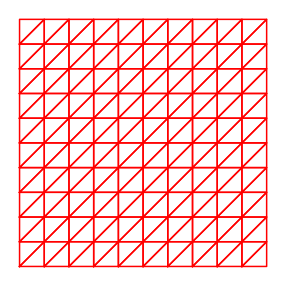

In [18]:

xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
nelemsx, nelemsy = 10,10
nelems = nelemsx * nelemsy
nnodes = (nelemsx + 1) * (nelemsy + 1)
node_coords, node_l2g, p_elem2nodes, elem2nodes = solutions._set_trimesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)
nodes_on_boundary = solutions._set_trimesh_boundary(nelemsx, nelemsy)
fig = matplotlib.pyplot.figure(figsize=(5,5))
ax = matplotlib.pyplot.subplot(1, 1, 1)
ax.set_aspect('equal')
ax.axis('off')
solutions._plot_mesh(p_elem2nodes, elem2nodes,node_coords , color='red') 

matplotlib.pyplot.show()


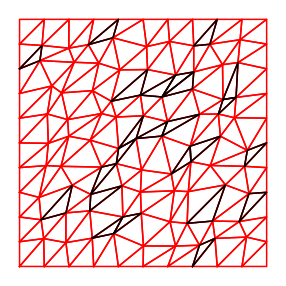

In [19]:
node_coords_dep=depl(p_elem2nodes, elem2nodes,node_coords,30)

#On calcule l'aspect ratio des élements perturbés, si l'aspect ratio est supérieur à 2, on considere que l'element ne satisfait pas le critére
a= compute_aspect_ratio_of_element_tri(node_coords, p_elem2nodes, elem2nodes)
b=[] 
for i in range(len(a)):
    if a[i]>2:
        b.append(i)
    

fig = matplotlib.pyplot.figure(figsize=(5,5))
ax = matplotlib.pyplot.subplot(1, 1, 1)
ax.set_aspect('equal')
ax.axis('off')
solutions._plot_mesh(p_elem2nodes, elem2nodes,node_coords , color='red')
for i in b:
    elem=i
    solutions._plot_elem(p_elem2nodes, elem2nodes, node_coords, elem, color='black')
matplotlib.pyplot.show()  


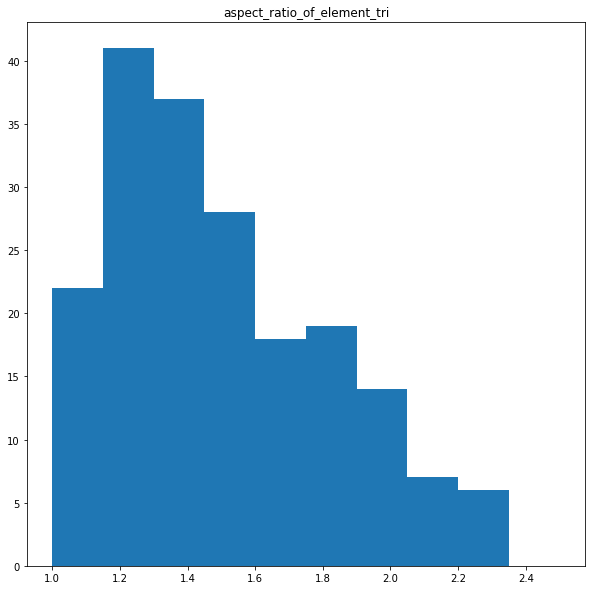

In [20]:
# Histogramme 
import matplotlib.pyplot as plt
fig = matplotlib.pyplot.figure(figsize=(10,10))
a =compute_aspect_ratio_of_element_tri(node_coords, p_elem2nodes, elem2nodes)
_ = plt.hist(a,range=(1,2.5))  # arguments are passed to np.histogram
plt.title("aspect_ratio_of_element_tri")
plt.show()

**Question 4 :**
Run the code to compute the finite element solution uh for different values of h and k. In the particular
case of an exact solution u
∗
, compute the error err = ||u
∗ − uh||.


Indication : Let nx (resp. ny) denotes the number of elements in the x (resp. ny) direction. consider
a mesh nx × ny defined as (16, 4), (16, 8), (16, 16).


Reminding the theoretical result of the finite element method err = ||u
∗ − uh|| ≤ Ch^α Evaluate α
and plot the error err upon h.


Reminding the theoretical result of the finite element method err = ||u
∗ − uh|| ≤ Ck^β Evaluate β
and plot the error err upon k.


Pour montrer que l’erreur est une puissance de h et de k (vecteur d’onde), on a (d’après la littérature) :
    

***Error=h^α***  et  ***Error=k^β*** , en passant au log et on obtient alpha et beta comme pente des droites ***log(error)=f(log(h))*** et ***log(error)=g(log(k))***


On utilise ***scipy.stats.linregress*** qui calcule une régression linéaire des moindres carrés pour deux séries de mesures et, permet donc d’avoir la pente de la droite.

**Question 4 - a** : Evaluation of α

<IPython.core.display.Javascript object>


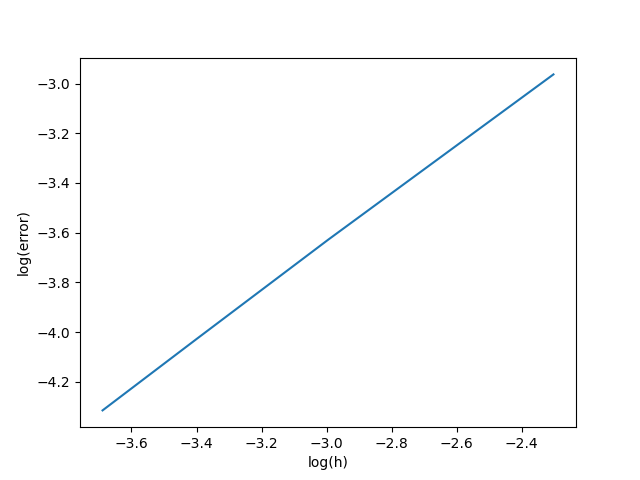

slope (α)  : 0.9744948431124271


In [33]:
from scipy.stats import linregress
%matplotlib notebook

def error_h(n):

    # -- set equation parameters
    # -- set geometry parameters
    xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
    wavenumber=numpy.pi
    nelemsx, nelemsy = n, n
    
    # -- generate mesh
    nnodes = (nelemsx + 1) * (nelemsy + 1)
    nelems = nelemsx * nelemsy * 2
    node_coords, p_elem2nodes, elem2nodes, node_l2g = zsolutions4students._set_square_trimesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)
    
    nnodes = node_coords.shape[0]
    nelems = len(p_elem2nodes)-1

    

    # -- set boundary geometry
    # boundary composed of nodes
    # .. todo:: Modify the lines below to select the ids of the nodes on the boundary of the different geometry.
    nodes_on_north = zsolutions4students._set_square_nodes_boundary_north(node_coords)
    nodes_on_south = zsolutions4students._set_square_nodes_boundary_south(node_coords)
    nodes_on_east = zsolutions4students._set_square_nodes_boundary_east(node_coords)
    nodes_on_west = zsolutions4students._set_square_nodes_boundary_west(node_coords)
    nodes_on_boundary = numpy.unique(numpy.concatenate((nodes_on_north, nodes_on_south, nodes_on_east, nodes_on_west)), )
    

    # -- set exact solution
    solexact = numpy.zeros((nnodes, 1), dtype=numpy.complex128)
    laplacian_of_solexact = numpy.zeros((nnodes, 1), dtype=numpy.complex128)
    for i in range(nnodes):
        x, y, z = node_coords[i, 0], node_coords[i, 1], node_coords[i, 2]
        # set: u(x,y) = e^{ikx}
        solexact[i] = numpy.exp(complex(0.,1.)*wavenumber*x)
        laplacian_of_solexact[i] = complex(0.,1.)*wavenumber*complex(0.,1.)*wavenumber * solexact[i]
    # ..warning: end

    # -- set dirichlet boundary conditions
    values_at_nodes_on_boundary = numpy.zeros((nnodes, 1), dtype=numpy.complex128)
    values_at_nodes_on_boundary[nodes_on_boundary] = solexact[nodes_on_boundary]

    # -- set finite element matrices and right hand side
    f_unassembled = numpy.zeros((nnodes, 1), dtype=numpy.complex128)

    
    for i in range(nnodes):
        # evaluate: (-\Delta - k^2) u(x,y) = ...
        f_unassembled[i] = - laplacian_of_solexact[i] - (wavenumber ** 2) * solexact[i]
    

    coef_k = numpy.ones((nelems, 1), dtype=numpy.complex128)
    coef_m = numpy.ones((nelems, 1), dtype=numpy.complex128)
    K, M, F = zsolutions4students._set_fem_assembly(p_elem2nodes, elem2nodes, node_coords, f_unassembled, coef_k, coef_m)
    A = K - wavenumber**2 * M
    B = F

    # -- apply Dirichlet boundary conditions
    A, B = zsolutions4students._set_dirichlet_condition(nodes_on_boundary, values_at_nodes_on_boundary, A, B)

    # -- solve linear system
    sol = scipy.linalg.solve(A, B)

    solreal = sol.reshape((sol.shape[0], ))
    
    solexactreal = solexact.reshape((solexact.shape[0], ))
    
    solerr = solreal - solexactreal
    
    return numpy.linalg.norm(solerr)


# On utilise scipy.stats.linregress qui calcule une régression linéaire des moindres carrés 
#pour deux séries de mesures et, permet donc d’avoir la pente de la droite.

fig, ax = matplotlib.pyplot.subplots()
h_set=[math.log(1/k) for k in range(10,50,10)]
error=[math.log(error_h(n)) for n in range(10,50,10)]
slope, intercept, r_value, p_value, std_err = linregress(h_set, error)
print("slope (α)  :",slope)
matplotlib.pyplot.xlabel("log(h)")
matplotlib.pyplot.ylabel("log(error)")
matplotlib.pyplot.plot(h_set,error)
matplotlib.pyplot.show()

**Question 4 - b** : Evaluation of β

<IPython.core.display.Javascript object>


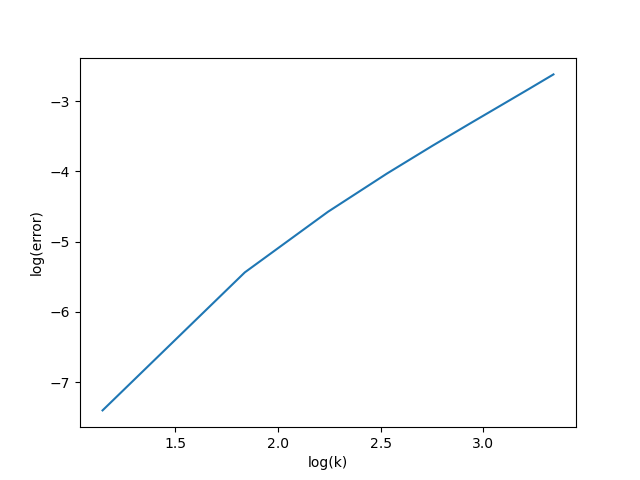

slope (β) : 2.111770845020977


In [34]:
from scipy.stats import linregress
%matplotlib notebook

def error_k(wavenumber):

    # -- set equation parameters
    # -- set geometry parameters
    xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
    nelemsx, nelemsy = 10, 10
    

    # -- generate mesh
    nnodes = (nelemsx + 1) * (nelemsy + 1)
    nelems = nelemsx * nelemsy * 2
    node_coords, p_elem2nodes, elem2nodes, node_l2g = zsolutions4students._set_square_trimesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)
    # .. todo:: Modify the line below to define a different geometry.
    # p_elem2nodes, elem2nodes, node_coords, node_l2g = ...
    nnodes = node_coords.shape[0]
    nelems = len(p_elem2nodes)-1

    # -- plot mesh

    # -- set boundary geometry
    # boundary composed of nodes
    
    nodes_on_north = zsolutions4students._set_square_nodes_boundary_north(node_coords)
    nodes_on_south = zsolutions4students._set_square_nodes_boundary_south(node_coords)
    nodes_on_east = zsolutions4students._set_square_nodes_boundary_east(node_coords)
    nodes_on_west = zsolutions4students._set_square_nodes_boundary_west(node_coords)
    nodes_on_boundary = numpy.unique(numpy.concatenate((nodes_on_north, nodes_on_south, nodes_on_east, nodes_on_west)), )
    

    
    # -- set exact solution
    solexact = numpy.zeros((nnodes, 1), dtype=numpy.complex128)
    laplacian_of_solexact = numpy.zeros((nnodes, 1), dtype=numpy.complex128)
    for i in range(nnodes):
        x, y, z = node_coords[i, 0], node_coords[i, 1], node_coords[i, 2]
        # set: u(x,y) = e^{ikx}
        solexact[i] = numpy.exp(complex(0.,1.)*wavenumber*x)
        laplacian_of_solexact[i] = complex(0.,1.)*wavenumber*complex(0.,1.)*wavenumber * solexact[i]
    

    # -- set dirichlet boundary conditions
    values_at_nodes_on_boundary = numpy.zeros((nnodes, 1), dtype=numpy.complex128)
    values_at_nodes_on_boundary[nodes_on_boundary] = solexact[nodes_on_boundary]

    # -- set finite element matrices and right hand side
    f_unassembled = numpy.zeros((nnodes, 1), dtype=numpy.complex128)

    for i in range(nnodes):
        # evaluate: (-\Delta - k^2) u(x,y) = ...
        f_unassembled[i] = - laplacian_of_solexact[i] - (wavenumber ** 2) * solexact[i]

    coef_k = numpy.ones((nelems, 1), dtype=numpy.complex128)
    coef_m = numpy.ones((nelems, 1), dtype=numpy.complex128)
    K, M, F = zsolutions4students._set_fem_assembly(p_elem2nodes, elem2nodes, node_coords, f_unassembled, coef_k, coef_m)
    A = K - wavenumber**2 * M
    B = F

    # -- apply Dirichlet boundary conditions
    A, B = zsolutions4students._set_dirichlet_condition(nodes_on_boundary, values_at_nodes_on_boundary, A, B)

    # -- solve linear system
    sol = scipy.linalg.solve(A, B)

    solreal = sol.reshape((sol.shape[0], ))
    
    solexactreal = solexact.reshape((solexact.shape[0], ))
    
    solerr = solreal - solexactreal
    
    return numpy.linalg.norm(solerr)

# On utilise scipy.stats.linregress qui calcule une régression linéaire des moindres carrés 
#pour deux séries de mesures et, permet donc d’avoir la pente de la droite.


fig, ax = matplotlib.pyplot.subplots()
wavenumbers=[math.log(k*numpy.pi) for k in range(1,10)]
error=[math.log(error_k(wavenumber)) for wavenumber in wavenumbers]
slope, intercept, r_value, p_value, std_err = linregress(wavenumbers, error)
print("slope (β) :",slope)
matplotlib.pyplot.xlabel("log(k)")
matplotlib.pyplot.ylabel("log(error)")

matplotlib.pyplot.plot(wavenumbers,error)
matplotlib.pyplot.show()

On a fait le estimations présidentes en posant h=1/n où n le nombre d’éléments, mais pour des triangles ou même des rectangles, cette définition de la discrétisation n’est pas forcément correcte. C’est pourquoi on va définir 4 définitions différentes de la discrétisation h et voir pour chaque définition de h la valeur de α correspondant. Les quatre définitions de h sont les suivantes:

**hmax** : le plus grand arrête de l'élement.

**haverage** : le moyen des arrêtes de l'élement.

**rayon_sur_alpha** : inspiré de l’aspect ratio d’un élément triangulaire (h= 6r/√3 ou r le rayon du cercle inscrit avec Q=1).

**h_produit_rayon_cercles** : racine carrée du produit des rayons du cercle inscrit et celui du cercle circonscrit.




In [94]:
def hmax(node_coords, p_elem2nodes, elem2nodes):
    M=[]
    L=[]
    elem2nodes_list= elem2nodes.tolist()
    
    for i in range(0,len(elem2nodes_list),3):
        L.append(elem2nodes_list[i:i+3])
    for i in range(len(L)):
        M.append(edges_length(node_coords[L[i][0]],node_coords[L[i][1]],node_coords[L[i][2]])[-1])  
    return M
    
def haverage(node_coords, p_elem2nodes, elem2nodes):
    M=[]
    L=[]
    elem2nodes_list= elem2nodes.tolist()
    
    for i in range(0,len(elem2nodes_list),3):
        L.append(elem2nodes_list[i:i+3])
    for i in range(len(L)):
        M.append(sum(edges_length(node_coords[L[i][0]],node_coords[L[i][1]],node_coords[L[i][2]]))/3)   
    return M

def rayon_sur_alpha(node_coords, p_elem2nodes, elem2nodes):
    M=[]
    L=[]
    elem2nodes_list= elem2nodes.tolist()
    
    for i in range(0,len(elem2nodes_list),3):
        L.append(elem2nodes_list[i:i+3])
    for i in range(len(L)):
        A=aire_trinagle(node_coords[L[i][0]],node_coords[L[i][1]],node_coords[L[i][2]])
        P=perimetre_trinagle(node_coords[L[i][0]],node_coords[L[i][1]],node_coords[L[i][2]])
        r=(2*A)/P
        M.append(6*r/sqrt(3))
    return M

def h_produit_rayon_cercles(node_coords, p_elem2nodes, elem2nodes):
    M=[]
    L=[]
    elem2nodes_list= elem2nodes.tolist()
    
    for i in range(0,len(elem2nodes_list),3):
        L.append(elem2nodes_list[i:i+3])
    for i in range(len(L)):
        A=aire_trinagle(node_coords[L[i][0]],node_coords[L[i][1]],node_coords[L[i][2]])
        P=perimetre_trinagle(node_coords[L[i][0]],node_coords[L[i][1]],node_coords[L[i][2]])
        r=(2*A)/P
        R=(edges_length(node_coords[L[i][0]],node_coords[L[i][1]],node_coords[L[i][2]])[0]*edges_length(node_coords[L[i][0]],node_coords[L[i][1]],node_coords[L[i][2]])[1]*edges_length(node_coords[L[i][0]],node_coords[L[i][1]],node_coords[L[i][2]])[2])/(4*A)
        M.append(sqrt(R*r))
    return M



<IPython.core.display.Javascript object>


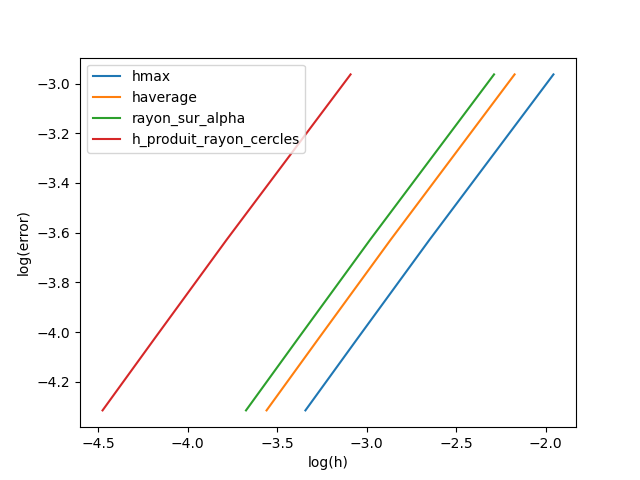

slope alpha (hmax) : 0.9744948431124278
slope alpha (haverage) : 0.9744948431124277
slope alpha (rayon_sur_alpha) : 0.9744948431124302
slope alpha (h_produit_rayon_cercles) : 0.9744948431124276


In [98]:
from scipy.stats import linregress
%matplotlib notebook

def error_h_(n):

   
    # -- set equation parameters
    # -- set geometry parameters
    xmin, xmax, ymin, ymax = 0.0, 1.0, 0.0, 1.0
    wavenumber=numpy.pi
    nelemsx, nelemsy = n, n
    
    

    # -- generate mesh
    nnodes = (nelemsx + 1) * (nelemsy + 1)
    nelems = nelemsx * nelemsy * 2
    node_coords, p_elem2nodes, elem2nodes, node_l2g = zsolutions4students._set_square_trimesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)
    
    #Les differentes def de h
    hmax_=max(hmax(node_coords, p_elem2nodes, elem2nodes)) # on prend le max des valeurs de h des elements 
    haverage_=max(haverage(node_coords, p_elem2nodes, elem2nodes))
    rayon_sur_alpha_=max(rayon_sur_alpha(node_coords, p_elem2nodes, elem2nodes))
    h_produit_rayon_cercles_=max(h_produit_rayon_cercles(node_coords, p_elem2nodes, elem2nodes))
    
    
    nnodes = node_coords.shape[0]
    nelems = len(p_elem2nodes)-1

    nodes_on_north = zsolutions4students._set_square_nodes_boundary_north(node_coords)
    nodes_on_south = zsolutions4students._set_square_nodes_boundary_south(node_coords)
    nodes_on_east = zsolutions4students._set_square_nodes_boundary_east(node_coords)
    nodes_on_west = zsolutions4students._set_square_nodes_boundary_west(node_coords)
    nodes_on_boundary = numpy.unique(numpy.concatenate((nodes_on_north, nodes_on_south, nodes_on_east, nodes_on_west)), )
    
    solexact = numpy.zeros((nnodes, 1), dtype=numpy.complex128)
    laplacian_of_solexact = numpy.zeros((nnodes, 1), dtype=numpy.complex128)
    for i in range(nnodes):
        x, y, z = node_coords[i, 0], node_coords[i, 1], node_coords[i, 2]
        # set: u(x,y) = e^{ikx}
        solexact[i] = numpy.exp(complex(0.,1.)*wavenumber*x)
        laplacian_of_solexact[i] = complex(0.,1.)*wavenumber*complex(0.,1.)*wavenumber * solexact[i]
    
    values_at_nodes_on_boundary = numpy.zeros((nnodes, 1), dtype=numpy.complex128)
    values_at_nodes_on_boundary[nodes_on_boundary] = solexact[nodes_on_boundary]

    f_unassembled = numpy.zeros((nnodes, 1), dtype=numpy.complex128)

    for i in range(nnodes):
        f_unassembled[i] = - laplacian_of_solexact[i] - (wavenumber ** 2) * solexact[i]
    

    coef_k = numpy.ones((nelems, 1), dtype=numpy.complex128)
    coef_m = numpy.ones((nelems, 1), dtype=numpy.complex128)
    K, M, F = zsolutions4students._set_fem_assembly(p_elem2nodes, elem2nodes, node_coords, f_unassembled, coef_k, coef_m)
    A = K - wavenumber**2 * M
    B = F

    A, B = zsolutions4students._set_dirichlet_condition(nodes_on_boundary, values_at_nodes_on_boundary, A, B)

    sol = scipy.linalg.solve(A, B)

    solreal = sol.reshape((sol.shape[0], ))
    solexactreal = solexact.reshape((solexact.shape[0], ))
    solerr = solreal - solexactreal
    return numpy.linalg.norm(solerr),hmax_ ,haverage_,rayon_sur_alpha_,h_produit_rayon_cercles_


fig, ax = matplotlib.pyplot.subplots()
hmax_set=[math.log(error_h_(n)[1]) for n in range(10,50,10)]
haverage_set=[math.log(error_h_(n)[2]) for n in range(10,50,10)]
rayon_sur_alpha_set=[math.log(error_h_(n)[3]) for n in range(10,50,10)]
h_produit_rayon_cercles_set=[math.log(error_h_(n)[4]) for n in range(10,50,10)]
error=[math.log(error_h_(n)[0]) for n in range(10,50,10)]
slope1 = linregress(hmax_set, error)[0]
slope2= linregress(haverage_set, error)[0]
slope3= linregress(rayon_sur_alpha_set, error)[0]
slope4= linregress(h_produit_rayon_cercles_set, error)[0]
print("slope alpha (hmax) :",slope1)
print("slope alpha (haverage) :",slope2)
print("slope alpha (rayon_sur_alpha) :",slope3)
print("slope alpha (h_produit_rayon_cercles) :",slope4)
matplotlib.pyplot.xlabel("log(h)")
matplotlib.pyplot.ylabel("log(error)")
matplotlib.pyplot.plot(hmax_set,error, label="hmax")
matplotlib.pyplot.plot(haverage_set,error, label="haverage")
matplotlib.pyplot.plot(rayon_sur_alpha_set,error, label="rayon_sur_alpha")
matplotlib.pyplot.plot(h_produit_rayon_cercles_set,error, label="h_produit_rayon_cercles")
matplotlib.pyplot.legend()
matplotlib.pyplot.show()

 ## **Part 2** : Control of acoustic wave by changing the shape of the boundary

**Question 5 :**
Write a function which compute the barycenter of one element.

In [15]:
#Qst 5
# given during the lectures

def compute_barycenter_of_element(node_coords, p_elem2nodes, elem2nodes):
    spacedim = node_coords.shape[1]
    nelems = p_elem2nodes.shape[0]-1
    elem_coords = numpy.zeros((nelems, spacedim), dtype=numpy.float64)
    for i in range(0, nelems):
        nodes=elem2nodes[p_elem2nodes[i]:p_elem2nodes[i+1]]
        elem_coords[i,:]=numpy.average(node_coords[nodes,:], axis=0)
    return elem_coords

**Question 6 :**
Write a function which split a mesh composed of quadrangles to a mesh composed of triangles.

In [16]:
#Qst 6
def split(p_elem2nodes, elem2nodes, node_coords):
    # changement de p_elem2nodes 
    p_elem2nodes_tri=numpy.asanyarray([i for i in range(0,6*(len(p_elem2nodes)+1),3)])
    elem2nodes_list= elem2nodes.tolist()
    i=3
    ct=0 # conteur pour répeter l'opération n/4 fois , où n/4 est le nombre d'élements rectangulaires
    n=len(elem2nodes_list)
    while ct<n/4:
        # insertion des elements triangulaires (diviser chaque carré en deux triangles) en placant les noeuds dans les bons endroits 
        elem2nodes_list.insert(i,elem2nodes_list[i-3])
        elem2nodes_list.insert(i+1,elem2nodes_list[i-1])
        i+=6
        ct+=1 
    elem2nodes_tri=numpy.asanyarray(elem2nodes_list)
    return p_elem2nodes_tri, elem2nodes_tri, node_coords

**Question 7 :**
Write four functions which are devoted respectively to add one element to the mesh, to remove one
element to the mesh, to add one node to the mesh, to remove one node to the mesh.

In [17]:

def add_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes, elemid2nodes):
    n=p_elem2nodes[1] # n=3 pour des maillages triangulaires , n=4 pour des maillages quadrilatéres
    elem2nodes=numpy.append(elem2nodes, elemid2nodes) # L'ajout de l'élement
    p_elem2nodes=numpy.append(p_elem2nodes, p_elem2nodes[-1]+n) 
    
    return node_coords, p_elem2nodes, elem2nodes

def add_node_to_mesh(node_coords, p_elem2nodes, elem2nodes, nodeid_coords):
    node_coords=numpy.append(node_coords, [nodeid_coords[1]],axis=0)
    p_elem2nodes=numpy.append(p_elem2nodes,p_elem2nodes[-1])
    elem2nodes=numpy.append(elem2nodes, nodeid_coords[0])
    
    return node_coords, p_elem2nodes, elem2nodes

def remove_node_to_mesh(node_coords, p_elem2nodes, elem2nodes, nodeid):
    n=p_elem2nodes[1] # n=3 pour des maillages triangulaires , n=4 pour des maillages quadrilatéres
    
    node_coords = numpy.delete(node_coords, nodeid, 0)
    
    L=[]
    elem2nodes_list= elem2nodes.tolist() 
    
    for i in range(0,len(elem2nodes_list),n):
        L.append(elem2nodes_list[i:i+n]) # liste L qui contient des listes chacun represeantant un element
    
    M=[]
    for i in range(len(L)):
        if nodeid in L[i]:
            for k in range(n):
                M.append(i*n+k) # M liste qui contient les ids des élement à supprimer
                   
    elem2nodes = numpy.delete(elem2nodes, M)
               
    for i in range(0,elem2nodes.size):
        if elem2nodes[i]>nodeid:
            elem2nodes[i]=elem2nodes[i]-1 # actualiser les ids des noeuds
        
    
    return node_coords, p_elem2nodes, elem2nodes

def remove_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes, elemid):
    n=p_elem2nodes[1]
    #les id des noeuds qui compose l'element elemid
    indices=[n*elemid+k for k in range(n)]
    nodes_of_element=[elem2nodes[i] for i in indices]
    #Supprision de la suite des noueds qui compose l'element 
    elem2nodes = numpy.delete(elem2nodes, [n*elemid+k for k in range(n)]) 
    p_elem2nodes=p_elem2nodes[:-1]
    
    # supprision des noeuds qui restent libres sans elements
    M=[]
    for i in nodes_of_element:
        if i not in elem2nodes:
            M.append(i)
    # Décalage des id des noeuds à supprimer         
    for i in range(len(M)):
        for j in range(i+1,len(M)):
            if M[j]>M[i]:
                M[j]=M[j]-1
    # Supprision
    for i in M:
        node_coords, p_elem2nodes, elem2nodes=remove_node_to_mesh(node_coords, p_elem2nodes, elem2nodes, i)
                
    return node_coords, p_elem2nodes, elem2nodes

**Question 8 :**
Write a function which generates a mesh of a geometry where a fractal shape is defined on a given
boundary. The ‘level’ of the fractal should be provided by the user, independently of the number of
element of the mesh. Be careful that at each level the volume of the domain keeps constant.

Ma méthode est d'utiliser les barycentres des éléments qu'il faut supprimer. On commence par chercher les coordonnés de la barrière avec la fractale, puis construire un polygone fermé a partir de ces coordonnées. Ensuite, on fait un fonction qui détermine si un point défini par ses coordonnées s'il appartient ou pas à un polygone ; pour ce faire, il suffit de calculer le nombre de points d'intersections du droit horizontale commençant par le point en question jusqu'à l'infini (un nombre très grand :10000 par exemple), avec les bords du polygone; si le nombre d'intersections est impair, donc le point est à l'intérieur du polygone. On va appliquer ceci sur les barycentres des éléments du maillage, et puis après supprimer les éléments qui sont à l'intérieur ou à l'extérieure du polygone pour avoir la barrière fractalisée.

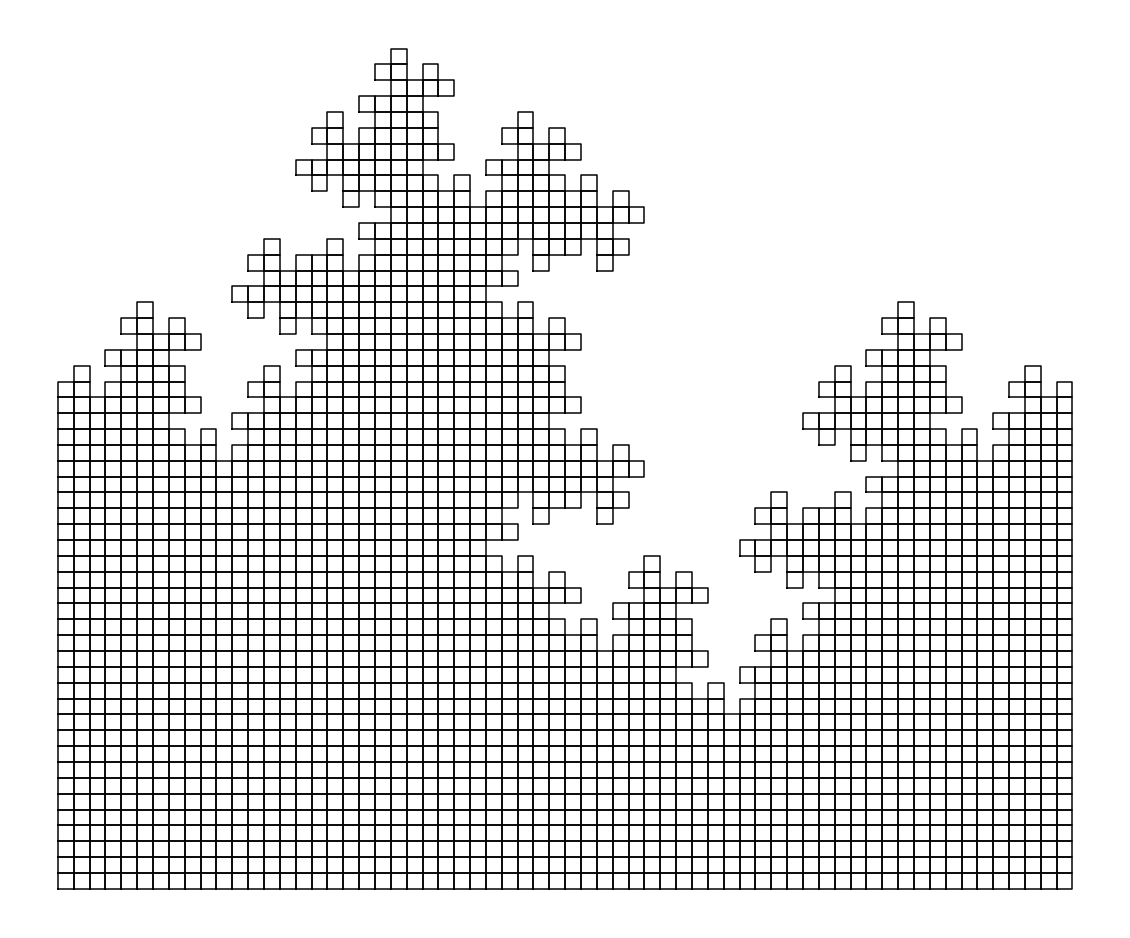

In [21]:
#Pour ce faire, je vais definir d'abord un ensemble de fontions intermédiares

# Cette focntion retourne la liste des coordonnées qui compose la barriére délimité par les points (x1,y1) et (x2,y2) avec une fractale
def fractal_coords(x1,y1,x2,y2,n):
    global L # L est la liste qui va recupere les coordonnées 
    if n==0:
        
        L.append([x2,y2,0.0])
        return 
    dist = ((x2-x1)**2+(y2-y1)**2)**0.5
    direction = math.atan2(y2-y1,x2-x1)
    px1, py1 = x1+dist/4*math.cos(direction), y1+dist/4*math.sin(direction)
    px2, py2 = px1+dist/4*math.cos(direction+math.radians(90)), py1+dist/4*math.sin(direction+math.radians(90))
    px3, py3 = px2+dist/4*math.cos(direction), py2+dist/4*math.sin(direction)
    px4, py4 = px3+dist/4*math.cos(direction-math.radians(90)), py3+dist/4*math.sin(direction-math.radians(90))
    px5, py5 = px4+dist/4*math.cos(direction-math.radians(90)), py4+dist/4*math.sin(direction-math.radians(90))
    px6, py6 = px5+dist/4*math.cos(direction), py5+dist/4*math.sin(direction)
    px7, py7 = x1+3*dist/4*math.cos(direction), y1+3*dist/4*math.sin(direction)
    
    fractal_coords(x1,y1,px1,py1,n-1)
    fractal_coords(px1,py1,px2,py2,n-1)
    fractal_coords(px2,py2,px3,py3,n-1)
    fractal_coords(px3,py3,px4,py4,n-1)
    fractal_coords(px4,py4,px5,py5,n-1)
    fractal_coords(px5,py5,px6,py6,n-1)
    fractal_coords(px6,py6,px7,py7,n-1)
    fractal_coords(px7,py7,x2,y2,n-1)
    



INT_MAX = 10000

# fonction qui retourne True si le point q apparteint au segment pr, False sinon
def on_Segment(p, q, r):

    if ((q[0] <= max(p[0], r[0])) & (q[0] >= min(p[0], r[0])) & (q[1] <= max(p[1], r[1])) & (q[1] >= min(p[1], r[1]))):
        return True
    return False

#Fonction qui retourne :
# 0 si p,q et r sont colinéaires
# 1 si p,q et r sont dans le sens des aiguilles d'une montre
# 2 si p,q et r sont dans le sens antihoraire
def orientation(p, q, r):

    valeur = (((q[1] - p[1]) *(r[0] - q[0])) -((q[0] - p[0]) *(r[1] - q[1])))
    if valeur == 0:
        return 0
    if valeur > 0:
        return 1 
    else:
        return 2
    
def do_intersect(p1, q1, p2, q2):

   # Trouver les quatre orientations nécessaires pour les cas généraux et spéciaux
    z1 = orientation(p1, q1, p2)
    z2 = orientation(p1, q1, q2)
    z3 = orientation(p2, q2, p1)
    z4 = orientation(p2, q2, q1)

    if (z1 != z2) and (z3 != z4): # le cas général
        return True
    
    # Cas particuliers
    # p1, q1 et p2 sont colinéaires et
    # p2 se trouve sur le segment p1q1
    if (z1 == 0) and (on_Segment(p1, p2, q1)):
        return True
    
    # p1, q1 et p2 sont colinéaires et
    # q2 se trouve sur le segment p1q1
    if (z2 == 0) and (on_Segment(p1, q2, q1)):
        return True
    
    # p2, q2 et p1 sont colinéaires et
    # p1 se trouve sur le segment p2q2
    if (z3 == 0) and (on_Segment(p2, p1, q2)):
        return True
    
    # p2, q2 et q1 sont colinéaires et
    # q1 se trouve sur le segment p2q2
    if (z4 == 0) and (on_Segment(p2, q1, q2)):
        return True
    return False

# Fonction qui retourne True si point "p" est dans un polygone "points", False sinon
def is_inside_polygon(points, p):

    n = len(points)
    # Il doit y avoir au moins 3 sommets dans le polygone
    if n < 3:
        return False

    # Créer un point pour le segment de droite de p à l'infini
    infini = (INT_MAX, p[1])
    
    # Compter le nombre de points du polygone dont la coordonnée y est égale à la coordonnée y du point.
    decrease = 0
    ct = i = 0
    
    while True:
        next = (i + 1) % n

        if(points[i][1] == p[1]):
            decrease += 1

        # Vérifier si le segment de ligne de 'p' à 'infini' coupe le segment de ligne de 'polygone[i]' à 'polygone[next]'.
        if (do_intersect(points[i],points[next],p, infini)):
            # Si le point 'p' est colinéaire avec le segment de droite 'i-next', alors vérifiez s'il se trouve
            # sur le segment. Si c'est le cas, retournez true, sinon false
            if orientation(points[i], p,points[next]) == 0:
                return on_Segment(points[i], p,points[next])
            ct += 1

        i = next
        
        if (i == 0):
            break
    # Réduire le nombre de points en diminuant le nombre de points, car ces points auraient été ajoutés deux fois.
    ct -= decrease
    # Retourne True si le nombre est impair, False sinon.
    return (ct % 2 == 1)


'''la fractale'''

n=3 #l'ordre de la fractale

# on choisit ces dimensions pour étre capable de générer les ordres 1,2 et 3 à volume constant 
# le code peut génerer n'importe quel ordre et à volume constant mais pour des ordres plus grands , il faut beaucoup d'elements
xmin, xmax, ymin, ymax = 0.0, 100.0, -50, 50.0
nelemsx, nelemsy = 64,64
nelems = nelemsx * nelemsy
nnodes = (nelemsx + 1) * (nelemsy + 1)
node_coords, node_l2g, p_elem2nodes, elem2nodes = solutions._set_quadmesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)

L=[[0.0,ymax,0.0],[0.0,0.0,0.0]]
fractal_coords(0,0,xmax,0,n)
L.append([xmax,ymax,0.0])


bary = compute_barycenter_of_element(node_coords, p_elem2nodes, elem2nodes)
polygone=L

# Supprimer les élements de la maillage dont le barycentre est dans le polygone
ct=-1
for point in bary:
    ct+=1
    if is_inside_polygon(polygone, point):
        numpy.delete(bary,ct)
        node_coords, p_elem2nodes, elem2nodes = remove_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes, ct)
        ct=ct-1 # décalage des indices aprés la supprision
        
fig = matplotlib.pyplot.figure(figsize=(20,20))
ax = matplotlib.pyplot.subplot(1, 1, 1)
ax.set_aspect('equal')
ax.axis('off')
solutions._plot_mesh(p_elem2nodes, elem2nodes, node_coords, color='black')

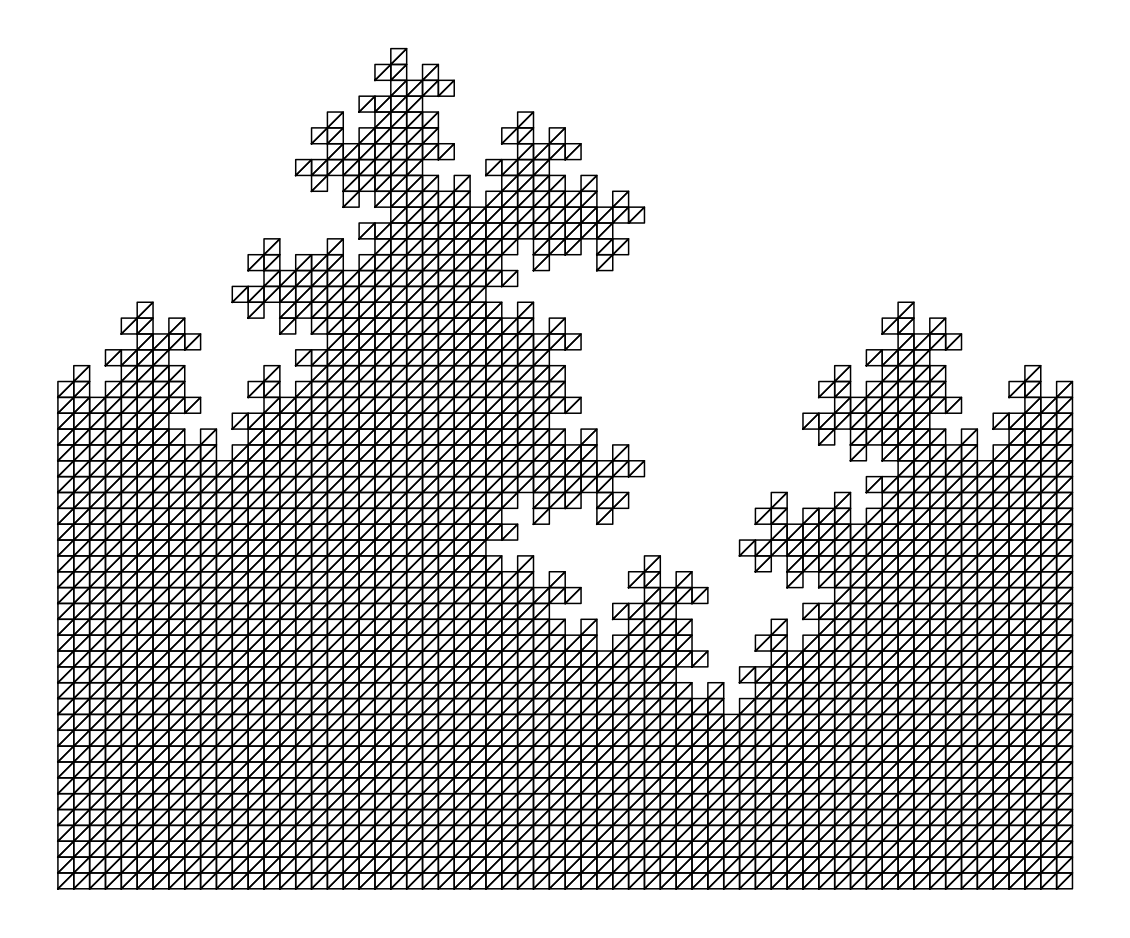

In [22]:
'''la fractale triangulaire : soit on utilise la fonction split soit en travaille sur un maillage triangulaire'''

n=3 #l'ordre de la fractale

# on choisit ces dimensions pour étre capable de générer les ordres 1,2 et 3 à volume constant 
# le code peut génerer n'importe quel ordre et à volume constant mais pour des ordres plus grands , il faut beaucoup d'elements
xmin, xmax, ymin, ymax = 0.0, 100.0, -50, 50.0
nelemsx, nelemsy = 64,64
nelems = nelemsx * nelemsy
nnodes = (nelemsx + 1) * (nelemsy + 1)
node_coords, node_l2g, p_elem2nodes, elem2nodes = solutions._set_trimesh(xmin, xmax, ymin, ymax, nelemsx, nelemsy)
nodes_on_boundary = solutions._set_trimesh_boundary(nelemsx, nelemsy)

L=[[0.0,ymax,0.0],[0.0,0.0,0.0]]
fractal_coords(0,0,xmax,0,n)
L.append([xmax,ymax,0.0])


bary = compute_barycenter_of_element(node_coords, p_elem2nodes, elem2nodes)
polygone=L

# Supprimer les élements de la maillage dont le barycentre est dans le polygone
ct=-1
for point in bary:
    ct+=1
    if is_inside_polygon(polygone, point):
        numpy.delete(bary,ct)
        node_coords, p_elem2nodes, elem2nodes = remove_elem_to_mesh(node_coords, p_elem2nodes, elem2nodes, ct)
        ct=ct-1 # décalage des indices aprés la supprision
        
fig = matplotlib.pyplot.figure(figsize=(20,20))
ax = matplotlib.pyplot.subplot(1, 1, 1)
ax.set_aspect('equal')
ax.axis('off')
solutions._plot_mesh(p_elem2nodes, elem2nodes, node_coords, color='black')

**Question 9 :**
Optional (high level in the general case) : Write a function which determine the sub-mesh of the
boundary, using the data structure presented in the lectures. Be careful in the numbering of the
boundary nodes and boundary elements, see l2g data structure.

In [23]:
def build_node2elems(p_elem2nodes, elem2nodes):
        
        # elem2nodes connectivity matrix
        e2n_coef = numpy.ones(len(elem2nodes), dtype=numpy.int64)
        e2n_mtx = scipy.sparse.csr_matrix((e2n_coef, elem2nodes, p_elem2nodes))
        # node2elems connectivity matrix
        n2e_mtx = e2n_mtx.transpose()
        n2e_mtx = n2e_mtx.tocsr()
        # output
        p_node2elems = n2e_mtx.indptr
        node2elems = n2e_mtx.indices

        return p_node2elems, node2elems
#Qst 9    
def boundary_nodes_id(p_elem2nodes, elem2nodes): 
    m=None
    n=p_elem2nodes[1] # Pour savoir le type de maillage: rectangulaire ou triangulaire
    if n==3:
        m=6 #Nombre d'elements associé à un noeud s'il n'est pas au bord (pour un maillage triangulaire)
    else:
        m=4 #Nombre d'elements associé à un noeud s'il n'est pas au bord (pour un maillage rectangulaire)
        
    L=build_node2elems(p_elem2nodes, elem2nodes)[0]
    M=[]
    boundary_nodes=[]
    for i in range(L.size-1):
        M.append(L[i+1]-L[i]) # M comporte le nombre d'elements associé à un noeud ( c'est la difference des élemenst successif de p_node2elems)
    for i in range(len(M)):
        if M[i]<m: # Si le nombre d"elements associé au noeud i est inferieur à m, donc il appartient au bord
            boundary_nodes.append(i)
    return numpy.asarray(boundary_nodes)

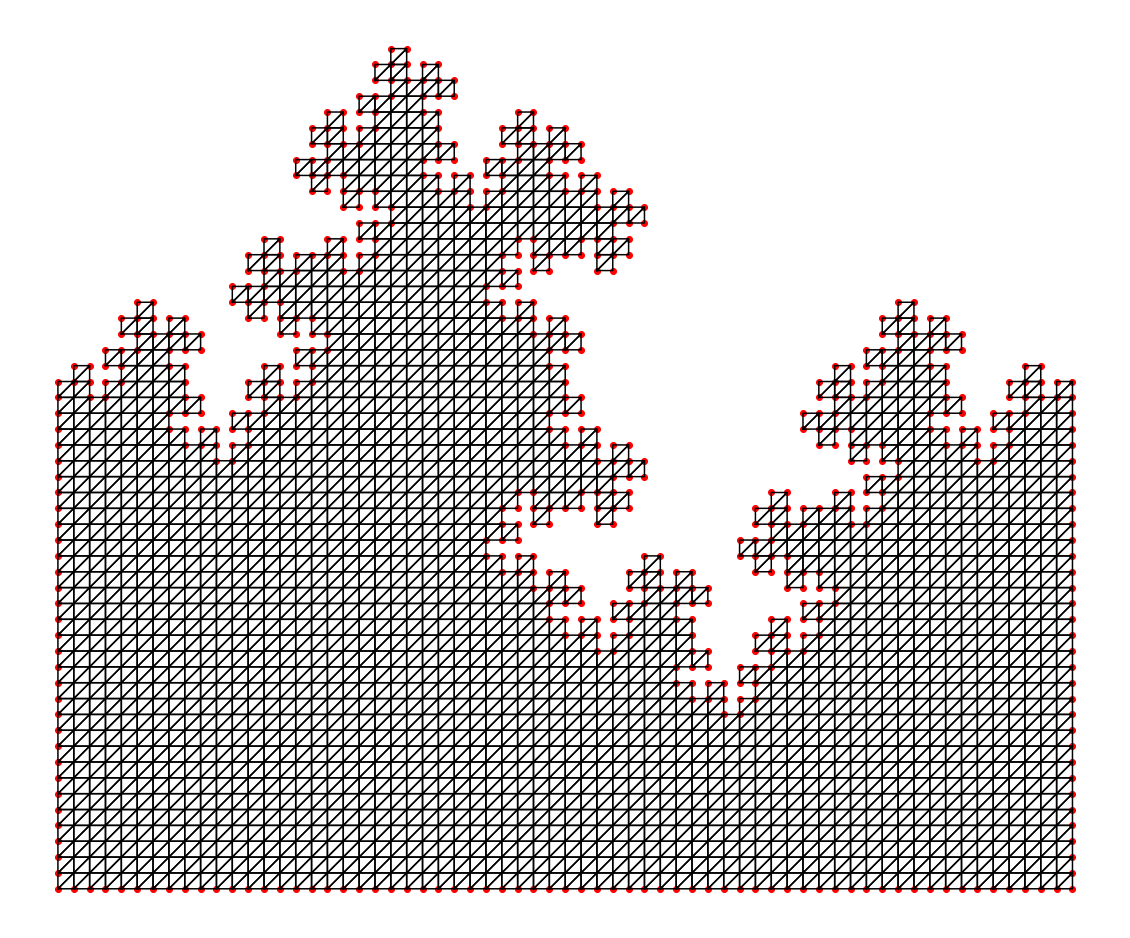

In [24]:
# Dessiner les noeuds de bords de la fractale
fig = matplotlib.pyplot.figure(figsize=(20,20))
ax = matplotlib.pyplot.subplot(1, 1, 1)
ax.set_aspect('equal')
ax.axis('off')
for i in boundary_nodes_id(p_elem2nodes, elem2nodes):
    node = i
    solutions._plot_node(p_elem2nodes, elem2nodes, node_coords, node, color='red', marker='o')
solutions._plot_mesh(p_elem2nodes, elem2nodes, node_coords, color='black')

End.